In [88]:
import performance_flow
import importlib
importlib.reload(performance_flow)
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import train_flow
importlib.reload(train_flow)
import pandas as pd
import numpy as np
from xgboost import XGBClassifier

# --------- #
# LEAVE ME  #
# --------- #
ticker = 'QQQ'
include_minute_feats = "N"
returns = [1, 2, 3, 5, 10, 20, 30]
df_daily, feature_sets, return_cols, daily_cols, feature_dict, features = train_flow.import_data(ticker, include_minute_feats, returns)

Available Feature Sets: dict_keys(['ma', 'rsi', 'macd', 'volume', 'atr_adx', 'volatility', 'vix_skew', 'experimental_slope', 'past_return'])


# Full Run
- Retrain ALL models through most recent aod
- Calculate performance
- Select and save top n
- Make predictions
- Ensemble

Horizon 1 Top 3 Models Saved
1 | run_separately | ma_sma-volu | 3 | 1.5 | 4 | 1
Running new predictions for horizon 1 | run_separately
1 | run_separately | volu-atr_adxvola | 3 | 1.5 | 4 | 1
Running new predictions for horizon 1 | run_separately
1 | run_separately | volu-vix_skew | 3 | 1.5 | 4 | 1
Running new predictions for horizon 1 | run_separately
1: 0.667 | 0.5
Horizon 2 Top 3 Models Saved
2 | run_separately | ma_lag-ma_sma | 3 | 1.5 | 4 | 2
Running new predictions for horizon 2 | run_separately
2 | run_separately | ma_sma-volu | 3 | 1.5 | 4 | 2
Running new predictions for horizon 2 | run_separately
2 | run_separately | volu-past_return | 3 | 1.5 | 4 | 2
Running new predictions for horizon 2 | run_separately
2: 0.625 | 0.762
Horizon 5 Top 3 Models Saved
5 | run_separately | ma_lag-ma_num | 3 | 1.5 | 4 | 5
Running new predictions for horizon 5 | run_separately
5 | run_separately | rsi_macd-volu | 3 | 1.5 | 4 | 5
Running new predictions for horizon 5 | run_separately
5 | run_separat

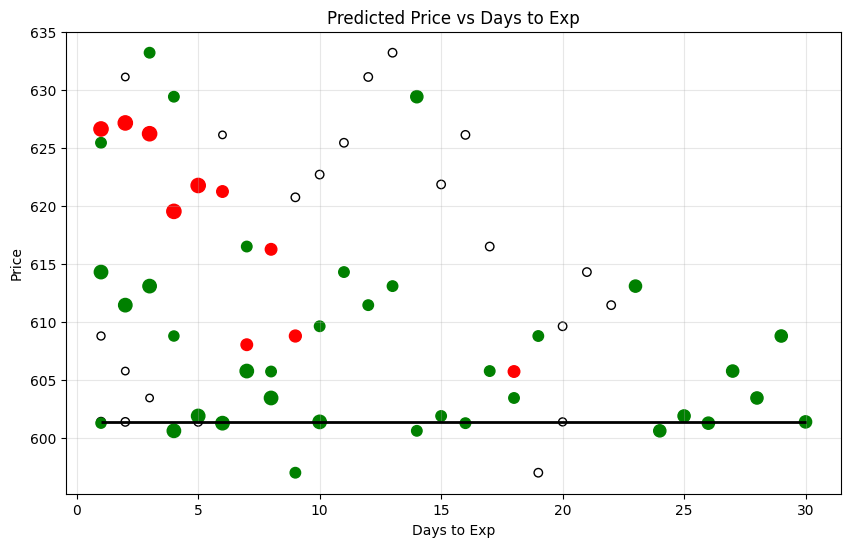

In [ ]:
from itertools import chain
import deployment_flow, performance_flow
import importlib
importlib.reload(deployment_flow)
importlib.reload(performance_flow)
import numpy as np
import matplotlib.pyplot as plt

def resolve_feature_cols(feature_set_name: str, features_dict: dict, sep: str = "-") -> list[str]:

    # --- Kitchen sink case ---
    if feature_set_name == "kitch_sink":
        all_cols = chain.from_iterable(features_dict.values())
        # dedupe preserve order
        seen = set()
        out = []
        for c in all_cols:
            if c not in seen:
                seen.add(c)
                out.append(c)
        return out

    # --- Normal composite case ---
    parts = feature_set_name.split(sep)

    cols = []
    for p in parts:
        if p not in features_dict:
            raise KeyError(f"{p} not in features_dict")
        cols.append(features_dict[p])

    # flatten + dedupe
    seen = set()
    out = []
    for c in chain.from_iterable(cols):
        if c not in seen:
            seen.add(c)
            out.append(c)

    return out

def pred_chart(df):

    x = df["Days_to_Exp"].astype(int)
    y = df["Predicted_Price"].astype(float)
    last_close = float(df["Last_Close"].iloc[0])

    # size scaling
    dist = np.abs(df["ensemble_pred"] - 0.5)
    sizes = 25 + 400 * dist   # adjust 400 to taste

    green_mask = df["ensemble_pred"] > 0.55
    red_mask   = df["ensemble_pred"] < 0.45
    neutral    = ~(green_mask | red_mask)

    plt.figure(figsize=(10,6))

    # neutral → white fill, black edge
    plt.scatter(x[neutral], y[neutral],
                s=sizes[neutral],
                facecolors="white", edgecolors="black")

    # green
    plt.scatter(x[green_mask], y[green_mask],
                s=sizes[green_mask], color="green")

    # red
    plt.scatter(x[red_mask], y[red_mask],
                s=sizes[red_mask], color="red")


    # last close line
    plt.hlines(last_close, xmin=x.min(), xmax=x.max(),
            colors="black", linewidth=2)

    plt.xlabel("Days to Exp")
    plt.ylabel("Price")
    plt.title("Predicted Price vs Days to Exp")
    plt.grid(True, alpha=0.3)
    plt.show()
  
def ensemble_perf(r, output_df):

    output_df.loc[output_df['pred'] < 0.45, 'pred'] = output_df['pred'] - 1

    composite_score = performance_flow.run_performance(pred_filtered[pred_filtered['horizon'] == r].dropna(), min_th, cov_th)
    output_df = composite_score[['pos_rate', 'pprec', 'nprec'] + keys].drop_duplicates().merge(output_df, on=keys, how="inner")

    output_df['pred_edge'] = np.where(output_df['pred'] > 0, output_df['pprec'] - output_df['pos_rate'], -output_df['nprec'] +(1-output_df['pos_rate'])).round(2)

    ensemble_df = (
        output_df
        .groupby('Date', as_index=False)
        .agg({
            'Date': 'first',
            'horizon': 'first',
            'pred_edge': 'sum'
        })
        .rename(columns={'pred_edge': 'ensemble_edge'})
    )
    ensemble_df['ensemble_pred'] = (ensemble_df['ensemble_edge'] / n + .5).round(2)
    ensemble_df['Days_to_Exp'] = ensemble_df.index + 1

    ensemble_perf_df = ensemble_df.merge(df_daily[['Date', f'Return_{r}']].dropna(), on='Date', how='inner')

    ensemble_perf_df['acc'] = np.where(
        ((ensemble_perf_df['ensemble_pred'] > 0.5) & (ensemble_perf_df[f'Return_{r}'] == 1)) |
        ((ensemble_perf_df['ensemble_pred'] < 0.5) & (ensemble_perf_df[f'Return_{r}'] == 0)),
        1,
        0
    )

    df = ensemble_perf_df[(ensemble_perf_df['ensemble_pred'] > .52) | (ensemble_perf_df['ensemble_pred'] < .48)].copy()

    # predicted class
    df["pred_class"] = np.where(df["ensemble_pred"] > 0.5, 1,
                        np.where(df["ensemble_pred"] < 0.5, 0, np.nan))

    # positive precision
    pos_mask = df["pred_class"] == 1
    # negative precision
    neg_mask = df["pred_class"] == 0
    
    pos_prec = np.round((df.loc[pos_mask, f"Return_{r}"] == 1).mean(), 3) if pos_mask.any() else np.nan
    neg_prec = np.round((df.loc[neg_mask, f"Return_{r}"] == 0).mean(), 3) if neg_mask.any() else np.nan
    print(f"{r}: {pos_prec} | {neg_prec}")

    return pos_prec, neg_prec

h=[1, 2, 5, 10, 20, 30]
master_results = []
master_preds = []
n = 3 # number of top models to select 
file_ext = "performance_all"
min_th = 0.55
cov_th = 0.75
perf_cutoff_date = '2025-09-01'
ensemble_all_df = pd.DataFrame()
ensemble_frames = []

# Retrain ALL
for r in h:
    
    df = pd.read_csv(f"h{r}_{file_ext}.csv")
    df = df.dropna().copy()
    #df = df.rename(columns={"feature_set": "features"})

    df["feature_cols"] = df["features"].apply(lambda x: resolve_feature_cols(x, feature_dict))

    grain_cols = ["horizon","features","train_years","min_feats","pi_size","model","pi_handling"]

    max_train = (
        df.groupby(grain_cols, as_index=False)["test_start"]
        .max()
        .rename(columns={"test_start": "max_test_start"})
    )

    models = (
        df[grain_cols].drop_duplicates(subset=grain_cols, keep="first")
        .merge(df[grain_cols + ["feature_cols"]].drop_duplicates(subset=grain_cols), on=grain_cols, how="left")
        .merge(max_train, on=grain_cols, how="left")   # <-- this is the missing piece
    )
    
    for row in models.itertuples(index=False):

        target_horizon = row.horizon
        pi_handling    = 'run_separately' #row.pi_handling
        type           = 'Actualized'
        feature_cols   = row.feature_cols   # list-of-cols wrapped in a list
        list_name      = row.features
        train_year     = row.train_years
        pi_year        = row.pi_size
        min_feat       = row.min_feats
        max_test_start = row.max_test_start
        days_assessed  = len(df_daily.iloc[r:][df_daily['Date'] > max_test_start].copy())
        groups = list_name.split("-")

        if days_assessed > 4:

            model = XGBClassifier(n_estimators=300, random_state=42, n_jobs=-1)
            model_name = "xgboost-3"

            print(f"{target_horizon} | {pi_handling} | {list_name} | {train_year} | {pi_year} | {min_feat} | {days_assessed}")
            results_df = deployment_flow.run_deploy_flow(days_assessed, r, pi_handling, feature_cols, df_daily, model_name, model,
                            train_year, pi_year, min_feat, list_name, feature_dict, groups, type)
            
            master_results.append(results_df)
    
    #print(f"Retrainig Done")
    if len(master_results) > 0: 
        
        master_results_df = pd.concat(master_results, ignore_index=True)
        performance_df = pd.read_csv(f"h{r}_{file_ext}.csv")
        df_concat = pd.concat([performance_df, master_results_df], ignore_index=True)    
        df_concat.to_csv(f"h{r}_{file_ext}.csv", index=False)

# Performance and Top n
for r in h:

    keys = ["horizon", "features", "train_years", "min_feats", "pi_size", "pi_handling", "model"]

    results_file_name = f"h{r}_{file_ext}.csv" # Match prior cell saved as file name horizon_2_baseline_new
    return_cols, perf_df = performance_flow.import_data(results_file_name, df_daily)
    perf_df = perf_df[perf_df['test_start'] >= perf_cutoff_date].rename(columns={"feature_set": "features"})
    composite_score = performance_flow.run_performance(perf_df[perf_df['horizon'] == r].dropna(), min_th, cov_th)
    bucket_df = performance_flow.bucket_scores(df_daily.dropna(), perf_df[perf_df['horizon'] == r].dropna(), returns, min_th, keys)

    max_models = 6
    edge_th = .1
    top_n = (
        composite_score
        .loc[
            (composite_score['pos_edge'] > edge_th) &
            (composite_score['neg_edge'] > edge_th),
            grain_cols
        ]
        .drop_duplicates()
    ).head(max_models)

    if len(top_n) < n:
        print("Not enough")

        top_n = (
        composite_score.sort_values("composite", ascending=False)
        .drop_duplicates(subset=["features"], keep="first").head(n).copy())

    # Ensure dtypes match so the join actually hits
    for df in (top_n, perf_df):

        df["horizon"] = r
        df["features"] = df["features"].astype(str)
        df["model"]       = df["model"].astype(str)
        df["pi_size"]     = df["pi_size"]
        df["pi_handling"]     = df["pi_handling"].astype(str)
        df["train_years"] = df["train_years"].astype(int)
        df["min_feats"]   = df["min_feats"].astype(int)

    # Filter master predictions to only rows matching one of the 10 configs
    pred_filtered = perf_df.merge(top_n[keys].drop_duplicates(), on=keys, how="inner")
    #print(len(pred_filtered))
    pred_filtered.to_csv(f"h{r}_top{n}_{file_ext}.csv", index=False)
    print(f"Horizon {r} Top {n} Models Saved")

    master_preds = []
    days_assessed = len(df_daily[df_daily[f"Return_{r}"].isna()])

    df = pd.read_csv(f"h{r}_top{n}_{file_ext}.csv")
    df["feature_cols"] = df["features"].apply(lambda x: resolve_feature_cols(x, feature_dict))

    grain_cols = ["horizon","features","train_years","min_feats","pi_size","model","pi_handling"]

    composite_score['pos_edge'] = (composite_score['pprec'] - composite_score['pos_rate']).round(2)
    composite_score['neg_edge'] = (composite_score['nprec'] - (1 - composite_score['pos_rate'])).round(2)

    top_n = (
        df[grain_cols].drop_duplicates(subset=grain_cols, keep="first")
        .merge(df[grain_cols + ["feature_cols"]].drop_duplicates(subset=grain_cols), on=grain_cols, how="left"))
    
    for row in top_n.itertuples(index=False):

        target_horizon = row.horizon
        pi_handling    = 'run_separately' #row.pi_handling
        type           = 'New_Predict'
        feature_cols   = row.feature_cols   # list-of-cols wrapped in a list
        list_name      = row.features
        train_year     = row.train_years
        pi_year        = row.pi_size
        min_feat       = row.min_feats
        groups = list_name.split("-")

        model = XGBClassifier(n_estimators=300, random_state=42, n_jobs=-1)
        model_name = "xgboost-3"

        print(f"{target_horizon} | {pi_handling} | {list_name} | {train_year} | {pi_year} | {min_feat} | {days_assessed}")
        results_df = deployment_flow.run_deploy_flow(days_assessed, r, pi_handling, feature_cols, df_daily, model_name, model,
                        train_year, pi_year, min_feat, list_name, feature_dict, groups, type)
        
        master_preds.append(results_df)
        #print(f"Horizon {r} Top {n} Models Predicted")

    master_preds_df = pd.concat(master_preds, ignore_index=True)
    predictions_df = master_preds_df.copy()
    composite_score[['pprec', 'nprec'] + keys].drop_duplicates().merge(predictions_df, on=keys, how="inner")

#predictions_df.sort_values(by='test_start', ascending=False).head(n)
    output_df = composite_score[['pos_rate', 'pprec', 'nprec'] + keys].drop_duplicates().merge(predictions_df, on=keys, how="inner")
    output_df = output_df.rename(columns={"test_start": "Date"})
    cols = ['Date', 'features', 'horizon', 'pos_rate', 'pred', 'pprec', 'nprec']
    output_df = output_df[cols].sort_values(by='Date').copy()
    output_df = output_df.merge(df_daily[['Close', 'Date']].round(2), on='Date', how="inner")
    output_df = output_df.rename(columns={"Close": "Predicted_Price"})
    last_close = (df_daily.sort_values("Date", ascending=False).iloc[0]["Close"].round(2))
    output_df['Last_Close'] = last_close
    output_df['LC_R_PP'] = round(output_df['Last_Close'] / output_df['Predicted_Price'] - 1, 3)

    output_df.loc[output_df['pred'] < 0.45, 'pred'] = output_df['pred'] - 1

    output_df['pred_edge'] = np.where(output_df['pred'] > 0, output_df['pprec'] - output_df['pos_rate'], -output_df['nprec'] +(1-output_df['pos_rate'])).round(2)

    ensemble_df = (
        output_df
        .groupby('Date', as_index=False)
        .agg({
            'Date': 'first',
            'horizon': 'first',
            'Predicted_Price': 'first',
            'Last_Close': 'first',
            'LC_R_PP': 'first',
            'pred_edge': 'sum'
        })
        .rename(columns={'pred_edge': 'ensemble_edge'})
    )
    ensemble_df['ensemble_pred'] = (ensemble_df['ensemble_edge'] / n + .5).round(2)
    ensemble_df['Days_to_Exp'] = ensemble_df.index + 1

    pos_prec, neg_prec = ensemble_perf(r, pred_filtered)
    ensemble_df['pos_prec'] = pos_prec
    ensemble_df['neg_prec'] = neg_prec

    ensemble_frames.append(ensemble_df)

ensemble_all_df = pd.concat(ensemble_frames, ignore_index=True)

pred_chart(ensemble_all_df)

In [107]:
composite_score['pos_edge'] = (composite_score['pprec'] - composite_score['pos_rate']).round(2)
composite_score['neg_edge'] = (composite_score['nprec'] - (1 - composite_score['pos_rate'])).round(2)

composite_score[grain_cols + ['pos_rate', 'pprec', 'nprec', 'pos_edge', 'neg_edge']].sort_values(by='neg_edge', ascending=False)

,horizon,features,train_years,min_feats,pi_size,model,pi_handling,pos_rate,pprec,nprec,pos_edge,neg_edge
1,30,ma_lag-ma_sma,3,4,1.5,xgboost-3,run_separately,0.65,0.84,0.62,0.19,0.27
6,30,ma_lag-vix_skew,3,4,1.5,xgboost-3,run_separately,0.64,0.72,0.54,0.08,0.18
44,30,experimental_slope-past_return,3,4,1.5,xgboost-3,run_separately,0.65,0.72,0.52,0.07,0.17
0,30,ma_lag-ma_rel,3,4,1.5,xgboost-3,run_separately,0.65,0.76,0.49,0.11,0.14
37,30,volu-experimental_slope,3,4,1.5,xgboost-3,run_separately,0.65,0.70,0.48,0.05,0.13
4,30,ma_lag-volu,3,4,1.5,xgboost-3,run_separately,0.66,0.76,0.46,0.10,0.12
42,30,vix_skew-experimental_slope,3,4,1.5,xgboost-3,run_separately,0.66,0.72,0.45,0.06,0.11
3,30,ma_lag-rsi_macd,3,4,1.5,xgboost-3,run_separately,0.65,0.74,0.45,0.09,0.10
5,30,ma_lag-atr_adxvola,3,4,1.5,xgboost-3,run_separately,0.64,0.71,0.46,0.07,0.10
33,30,rsi_macd-experimental_slope,3,4,1.5,xgboost-3,run_separately,0.68,0.73,0.42,0.05,0.10


In [122]:
top_n = (
composite_score.sort_values("composite", ascending=False)
.drop_duplicates(subset=["features"], keep="first").head(n).copy())
top_n

,horizon,model,train_years,features,pi_size,pi_handling,min_feats,pos_rate,records,bal_prec,...,pprec,nprec,cov_|0.75|,pprec_|0.75|,nprec_|0.75|,pos_preds,neg_preds,composite,pos_edge,neg_edge
1,30,xgboost-3,3,ma_lag-ma_sma,1.5,run_separately,4,0.65,88.0,0.73,...,0.84,0.62,0.99,0.84,0.62,51.0,37.0,0.65,0.19,0.27
6,30,xgboost-3,3,ma_lag-vix_skew,1.5,run_separately,4,0.64,88.0,0.63,...,0.72,0.54,0.89,0.73,0.64,60.0,28.0,0.53,0.08,0.18
0,30,xgboost-3,3,ma_lag-ma_rel,1.5,run_separately,4,0.65,86.0,0.62,...,0.76,0.49,0.92,0.78,0.47,49.0,37.0,0.51,0.11,0.14
